# ACCESS-OM3 and ACCESS-OM2 horizontal mean salinity drift from initial condition, vs depth and time

Related issue: https://github.com/ACCESS-Community-Hub/access-om3-25km-paper-1/issues/8

In [1]:
#parameters

### USER EDIT start
# esm_file='/g/data/ol01/access-om3-output/access-om3-025/MC_25km_jra_ryf-1.0-beta/experiment_datastore.json'
esm_file='/g/data/ol01/access-om3-output/access-om3-025/25km-iaf-test-for-AK-expt-7df5ef4c/datastore.json'
dpi=300
### USER EDIT stop

import os
from matplotlib import rcParams
%matplotlib inline
rcParams['figure.dpi']= dpi

plotfolder=f"/g/data/{os.environ['PROJECT']}/{os.environ['USER']}/access-om3-paper-figs/"
os.makedirs(plotfolder, exist_ok=True)

 # a similar cell under this means it's being run in batch
print("ESM datastore path: ",esm_file)
print("Plot folder path: ",plotfolder)

ESM datastore path:  /g/data/ol01/access-om3-output/access-om3-025/25km-iaf-test-for-AK-expt-7df5ef4c/datastore.json
Plot folder path:  /g/data/x77/amh157/access-om3-paper-figs/


In [2]:
import xarray as xr
import cf_xarray as cfxr
import cf_xarray.units
import pint_xarray
from pint import application_registry as ureg
import intake
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from distributed import Client
import cftime
import os
import matplotlib.pyplot as plt
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
from textwrap import wrap
xr.set_options(keep_attrs=True);  # cf_xarray works best when xarray keeps attributes by default

In [4]:
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 24
Total threads: 24,Total memory: 95.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40147,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:39861,Total threads: 1
Dashboard: /proxy/44765/status,Memory: 3.96 GiB
Nanny: tcp://127.0.0.1:43713,


### Load and plot data from ACCESS-OM3

In [5]:
exptname=os.path.basename(os.path.dirname(esm_file))

datastore = intake.open_esm_datastore(
    esm_file,
    columns_with_iterables=[
        "variable",
        "variable_long_name",
        "variable_standard_name",
        "variable_cell_methods",
        "variable_units"
    ]
)

In [6]:
exptname

'25km-iaf-test-for-AK-expt-7df5ef4c'

In [7]:
variable = "salt"
model_all = datastore.search(variable=variable, frequency="1mon").to_dask(
    xarray_open_kwargs = dict(
        chunks={"xh": -1, "time": -1},
        decode_timedelta=True
    ),
    xarray_combine_by_coords_kwargs=dict(
        compat="override",
        data_vars="minimal",
        coords="minimal"
    )
)[variable]

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


In [8]:
##### ONLY NEEDED FOR 25km-iaf-test-for-AK-expt-7df5ef4c !!!!!!!!!!!!!!!!!!!!!!!!!!!!!

# omit latitudes with grid bug https://github.com/ACCESS-NRI/ocean_model_grid_generator/issues/7
model_all = model_all.isel(yh=slice(10, None))

# BUG: horizontal mean needs to be area-weighted - use xgcm?

### Global

In [9]:
%%time
model = model_all.mean('yh').mean('xh').load()

CPU times: user 1min 3s, sys: 26.9 s, total: 1min 30s
Wall time: 2min 39s


Text(0.5, 1.0, 'UNWEIGHTED Horizontal mean Salinity drift from initial\ncondition in 25km-iaf-test-for-AK-expt-7df5ef4c')

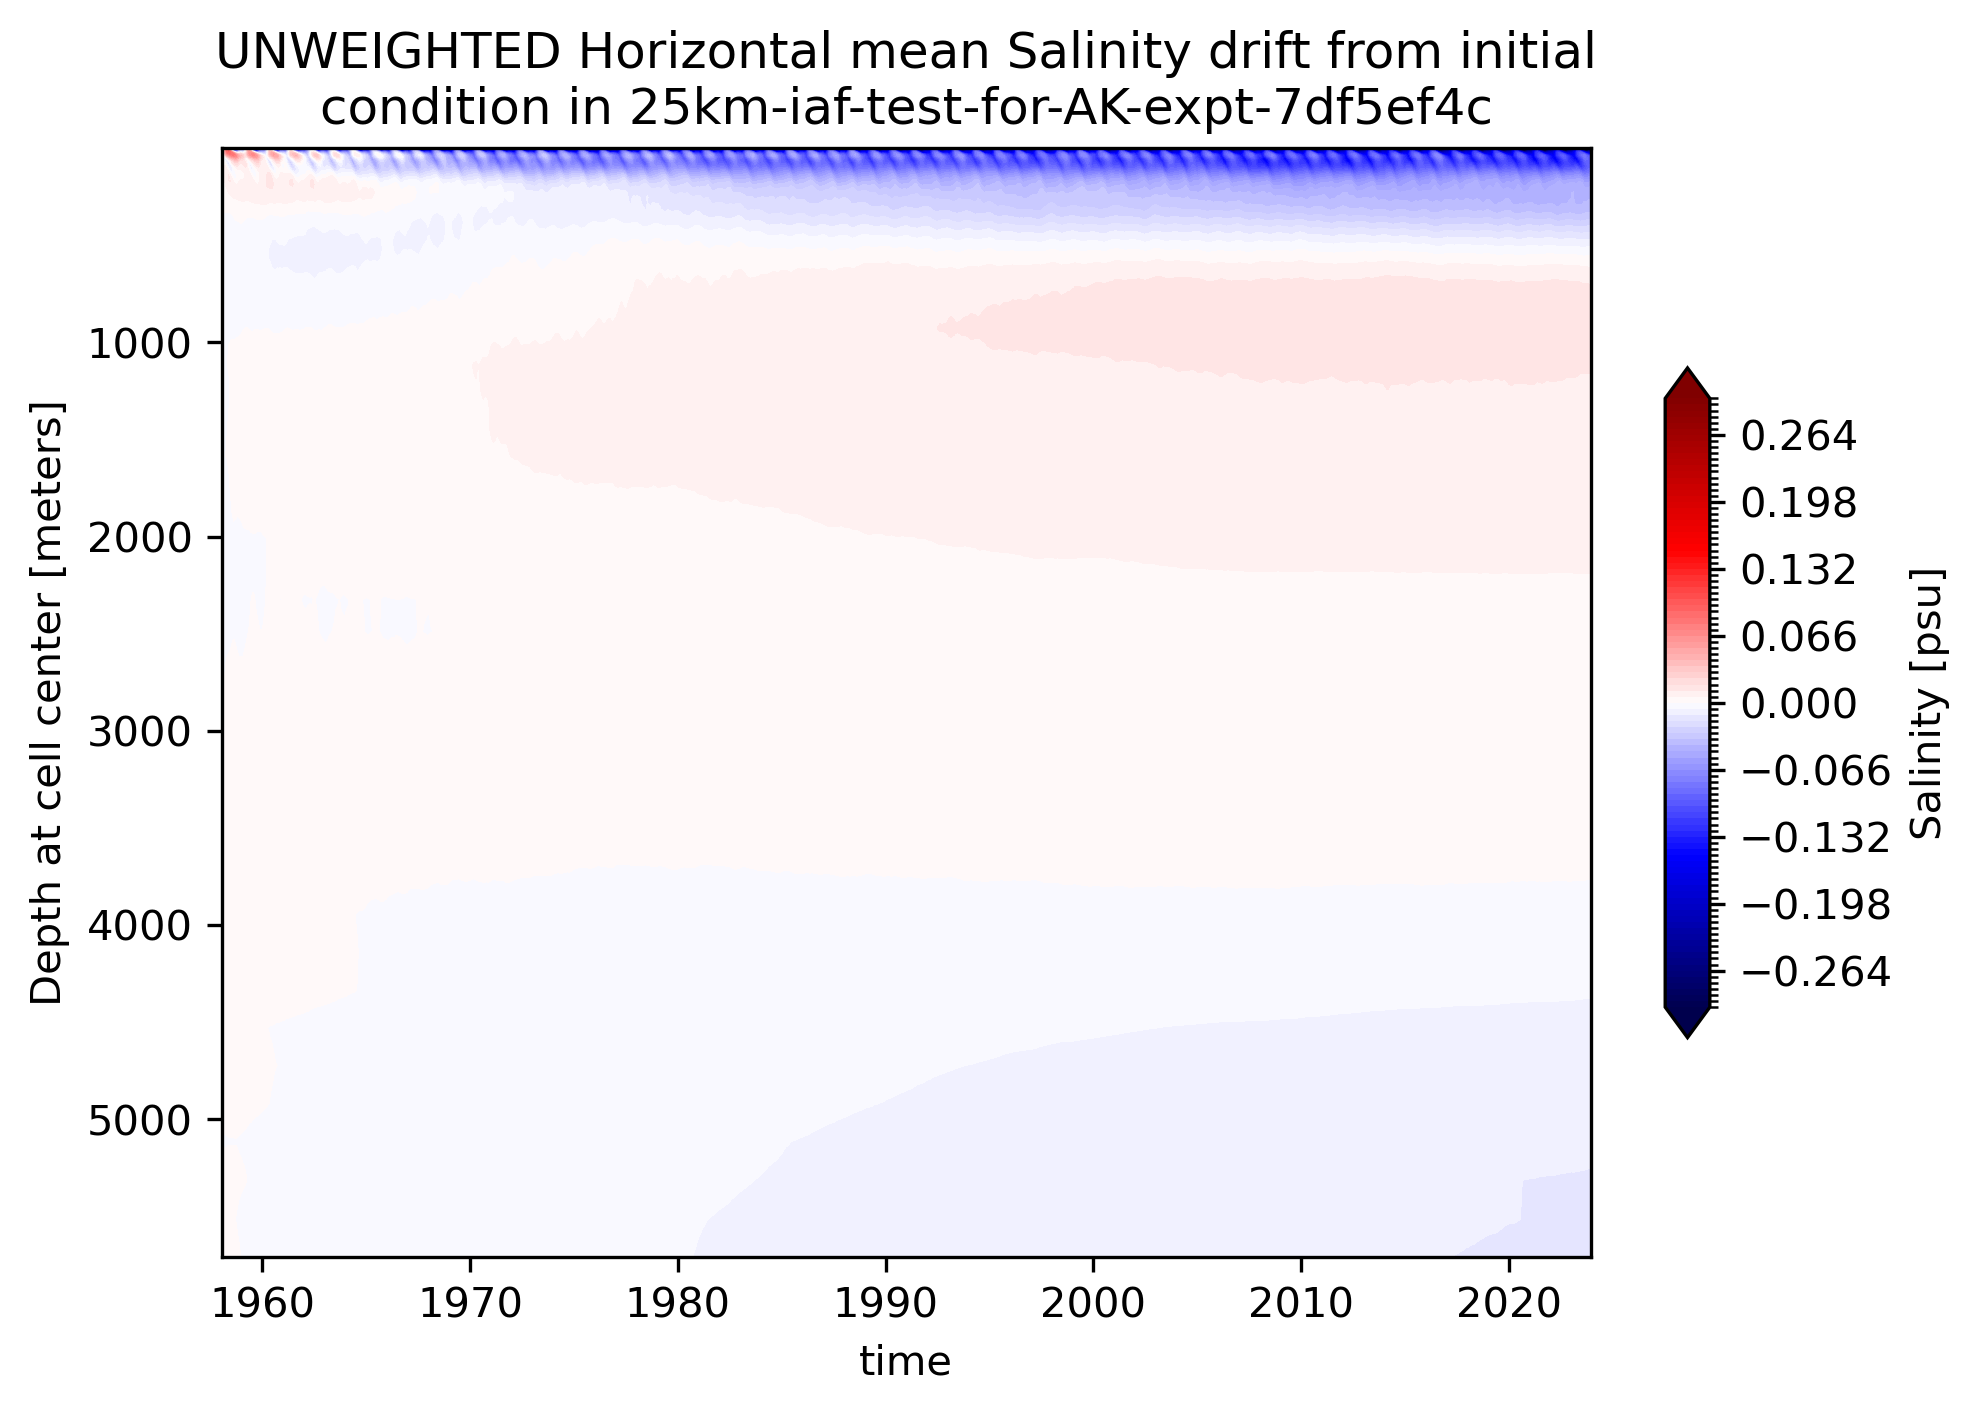

In [10]:
(model-model.isel(time=0)).transpose().plot.contourf(
    levels=101,
    vmin=-0.3,
    vmax=0.3,
    extend="both",
    cmap='seismic',
    cbar_kwargs={"label": "\n".join(wrap(f"{model.attrs['long_name']} [{model.attrs['units']}]", 45)),
                 "fraction": 0.03, "aspect": 15, "shrink": 0.7},
)
plt.gca().invert_yaxis()
plt.title("\n".join(wrap(f"UNWEIGHTED Horizontal mean {model.attrs['long_name']} drift from initial condition in {exptname}", 60)))


### Sulu Sea
- https://github.com/ACCESS-NRI/access-om3-configs/issues/625
- https://iilss.net/wp-content/uploads/2023/02/image-126.png

In [10]:
xslice = slice(119-360, 122-360)
yslice = slice(6, 10)

CPU times: user 1.5 s, sys: 307 ms, total: 1.81 s
Wall time: 4.53 s


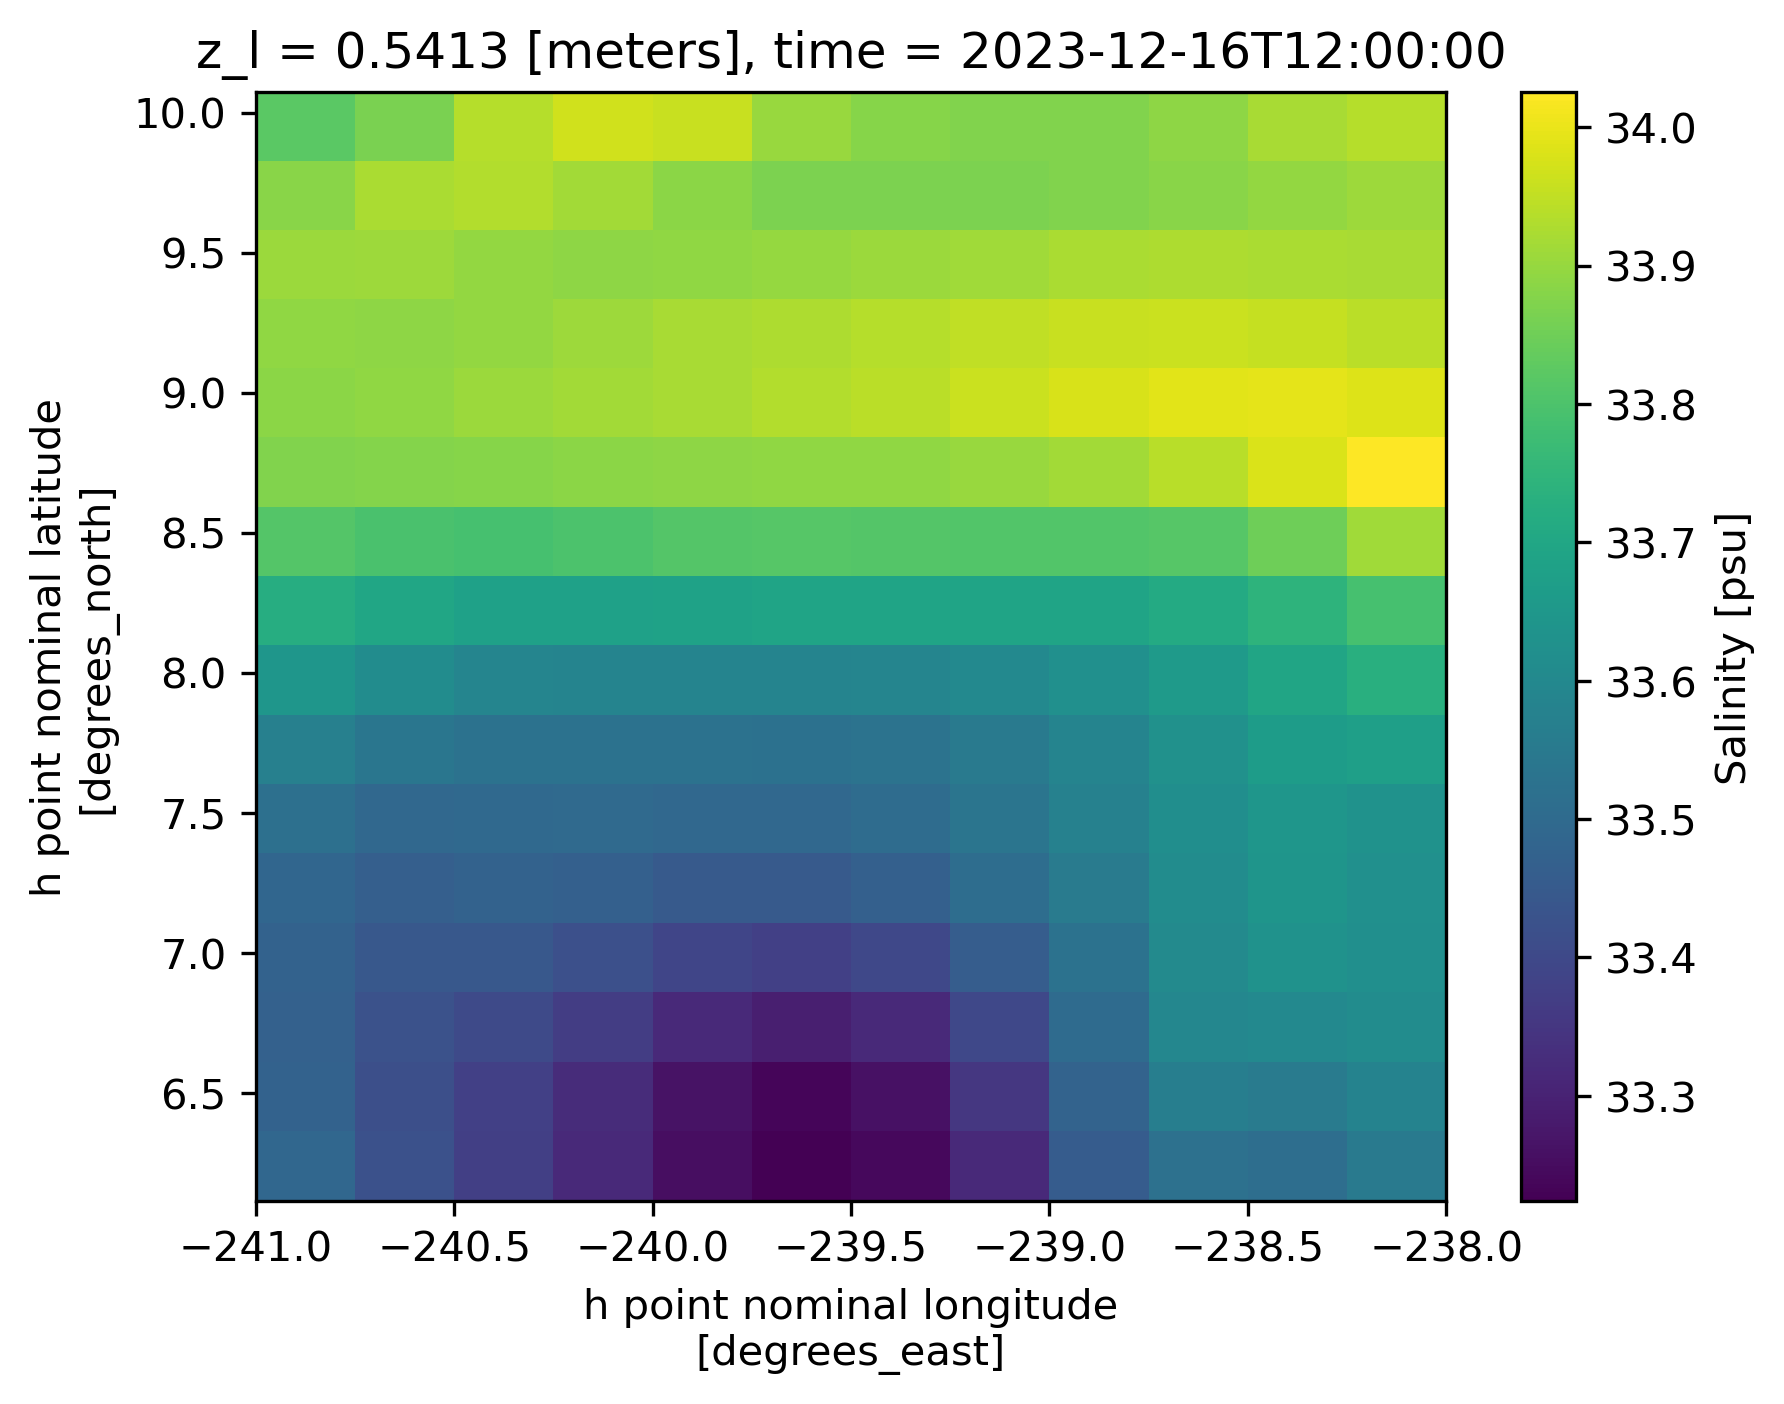

In [11]:
%%time
model_all.sel(xh=xslice).sel(yh=yslice).isel(time=-1).isel(z_l=0).plot()

In [12]:
%%time
model = model_all.sel(xh=xslice).sel(yh=yslice).mean('yh').mean('xh').load()

CPU times: user 4.11 s, sys: 1.24 s, total: 5.35 s
Wall time: 15.2 s


Text(0.5, 1.0, 'Sulu Sea UNWEIGHTED Horizontal mean Salinity drift from\ninitial condition in 25km-iaf-test-for-AK-expt-7df5ef4c')

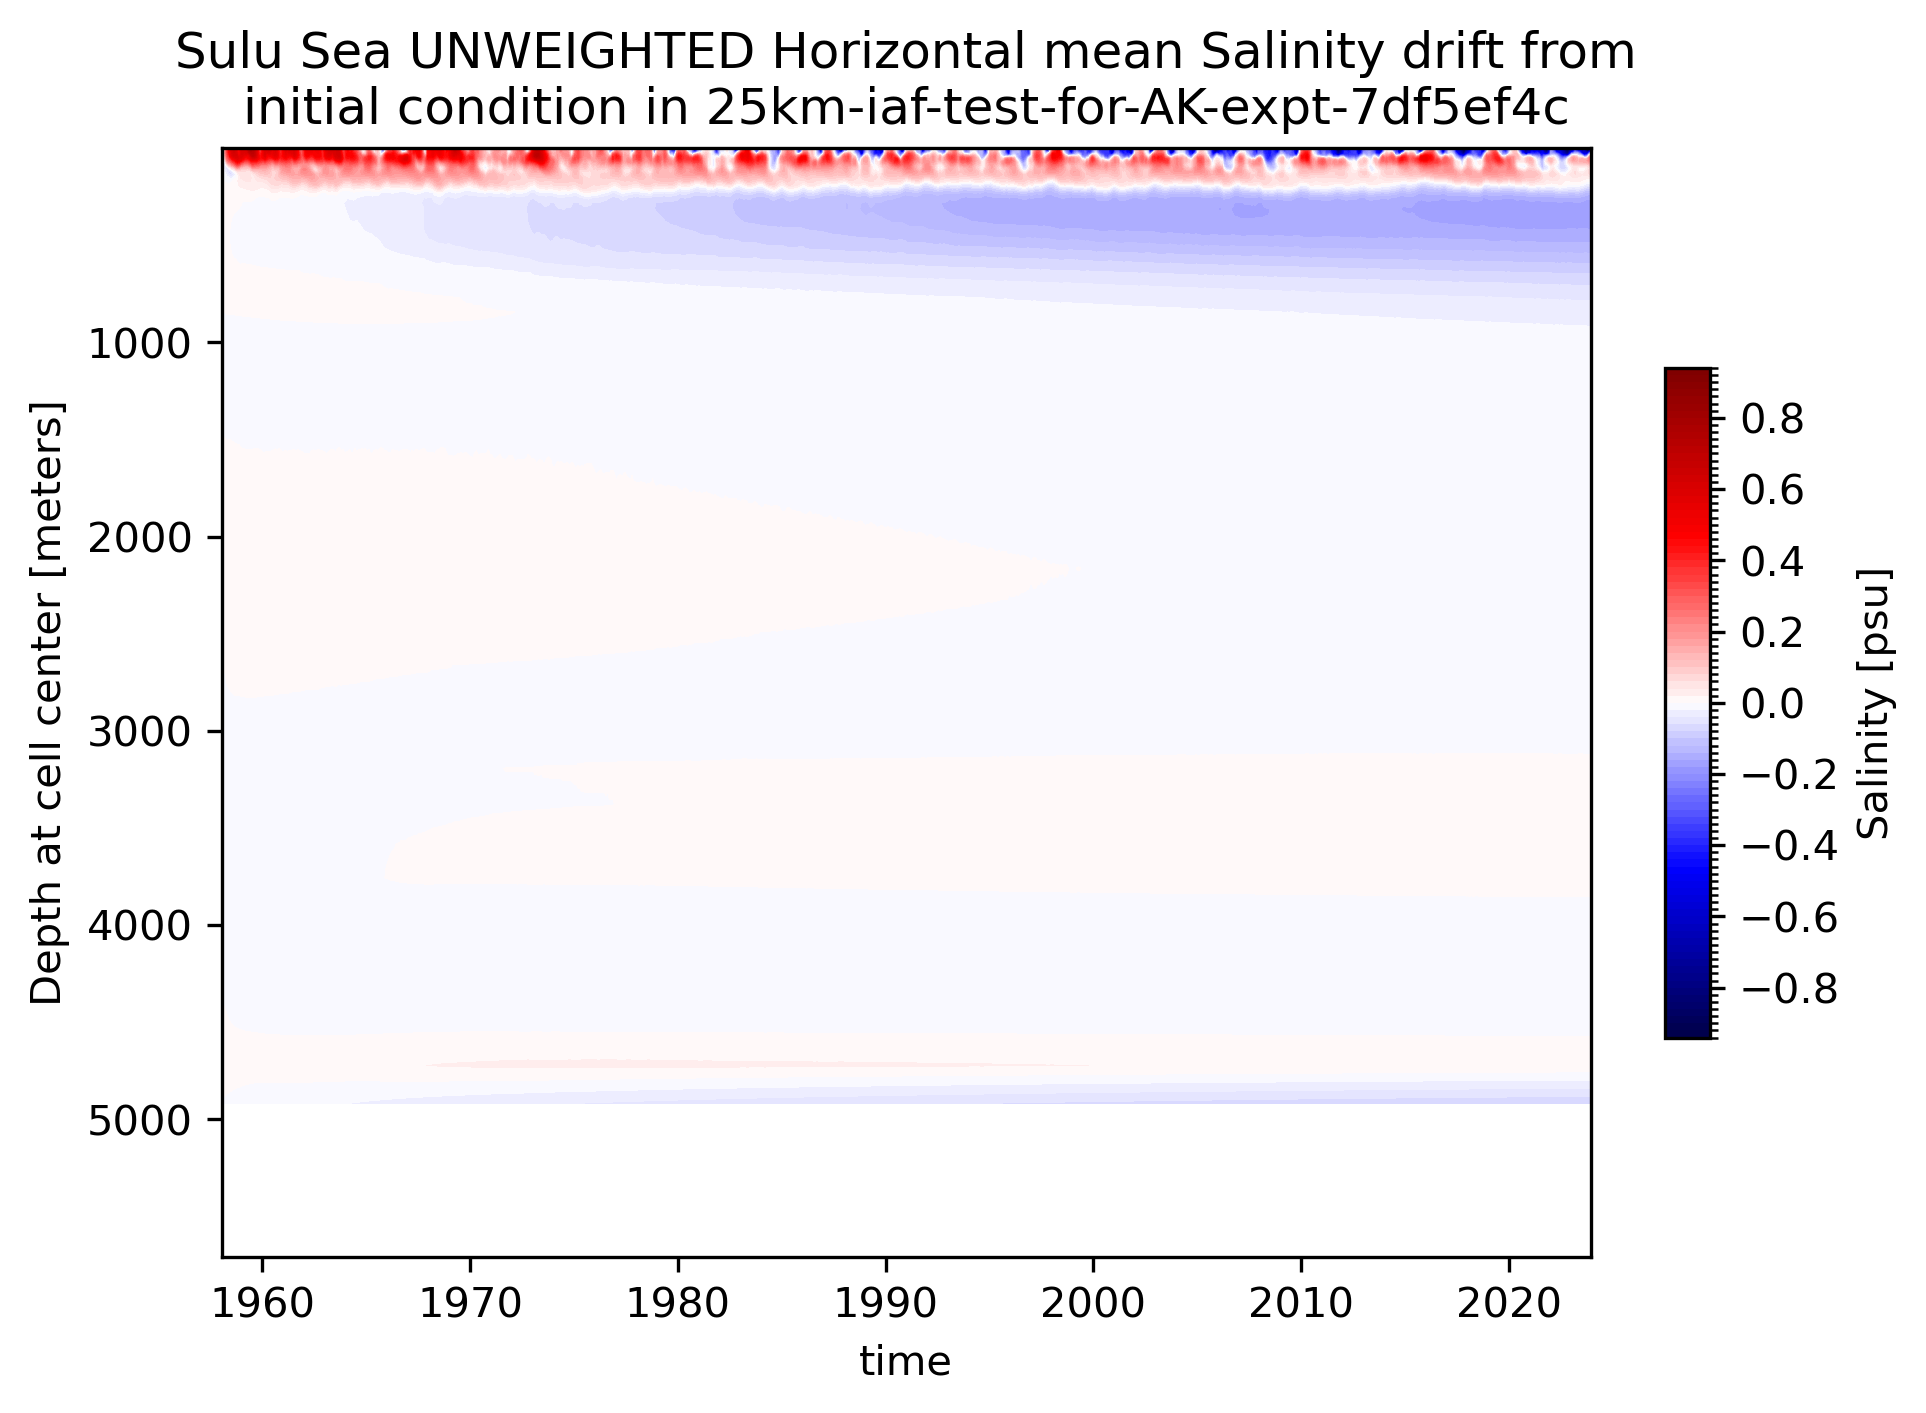

In [13]:
(model-model.isel(time=0)).transpose().plot.contourf(
    levels=101,
    # vmin=-0.3,
    # vmax=0.3,
    # extend="both",
    cmap='seismic',
    cbar_kwargs={"label": "\n".join(wrap(f"{model.attrs['long_name']} [{model.attrs['units']}]", 45)),
                 "fraction": 0.03, "aspect": 15, "shrink": 0.7},
)
plt.gca().invert_yaxis()
plt.title("\n".join(wrap(f"Sulu Sea UNWEIGHTED Horizontal mean {model.attrs['long_name']} drift from initial condition in {exptname}", 60)))

### Black Sea
- https://github.com/ACCESS-NRI/access-om3-configs/issues/729

In [14]:
# match SSS_Restoring_Timeseries.ipynb
# "Black Sea": {"lat1": 40.5, "lat2": 48, "lon1": 27.5, "lon2": 43},
xslice = slice(27.5, 43)
yslice = slice(40.5, 48)

CPU times: user 1.35 s, sys: 236 ms, total: 1.58 s
Wall time: 4.27 s


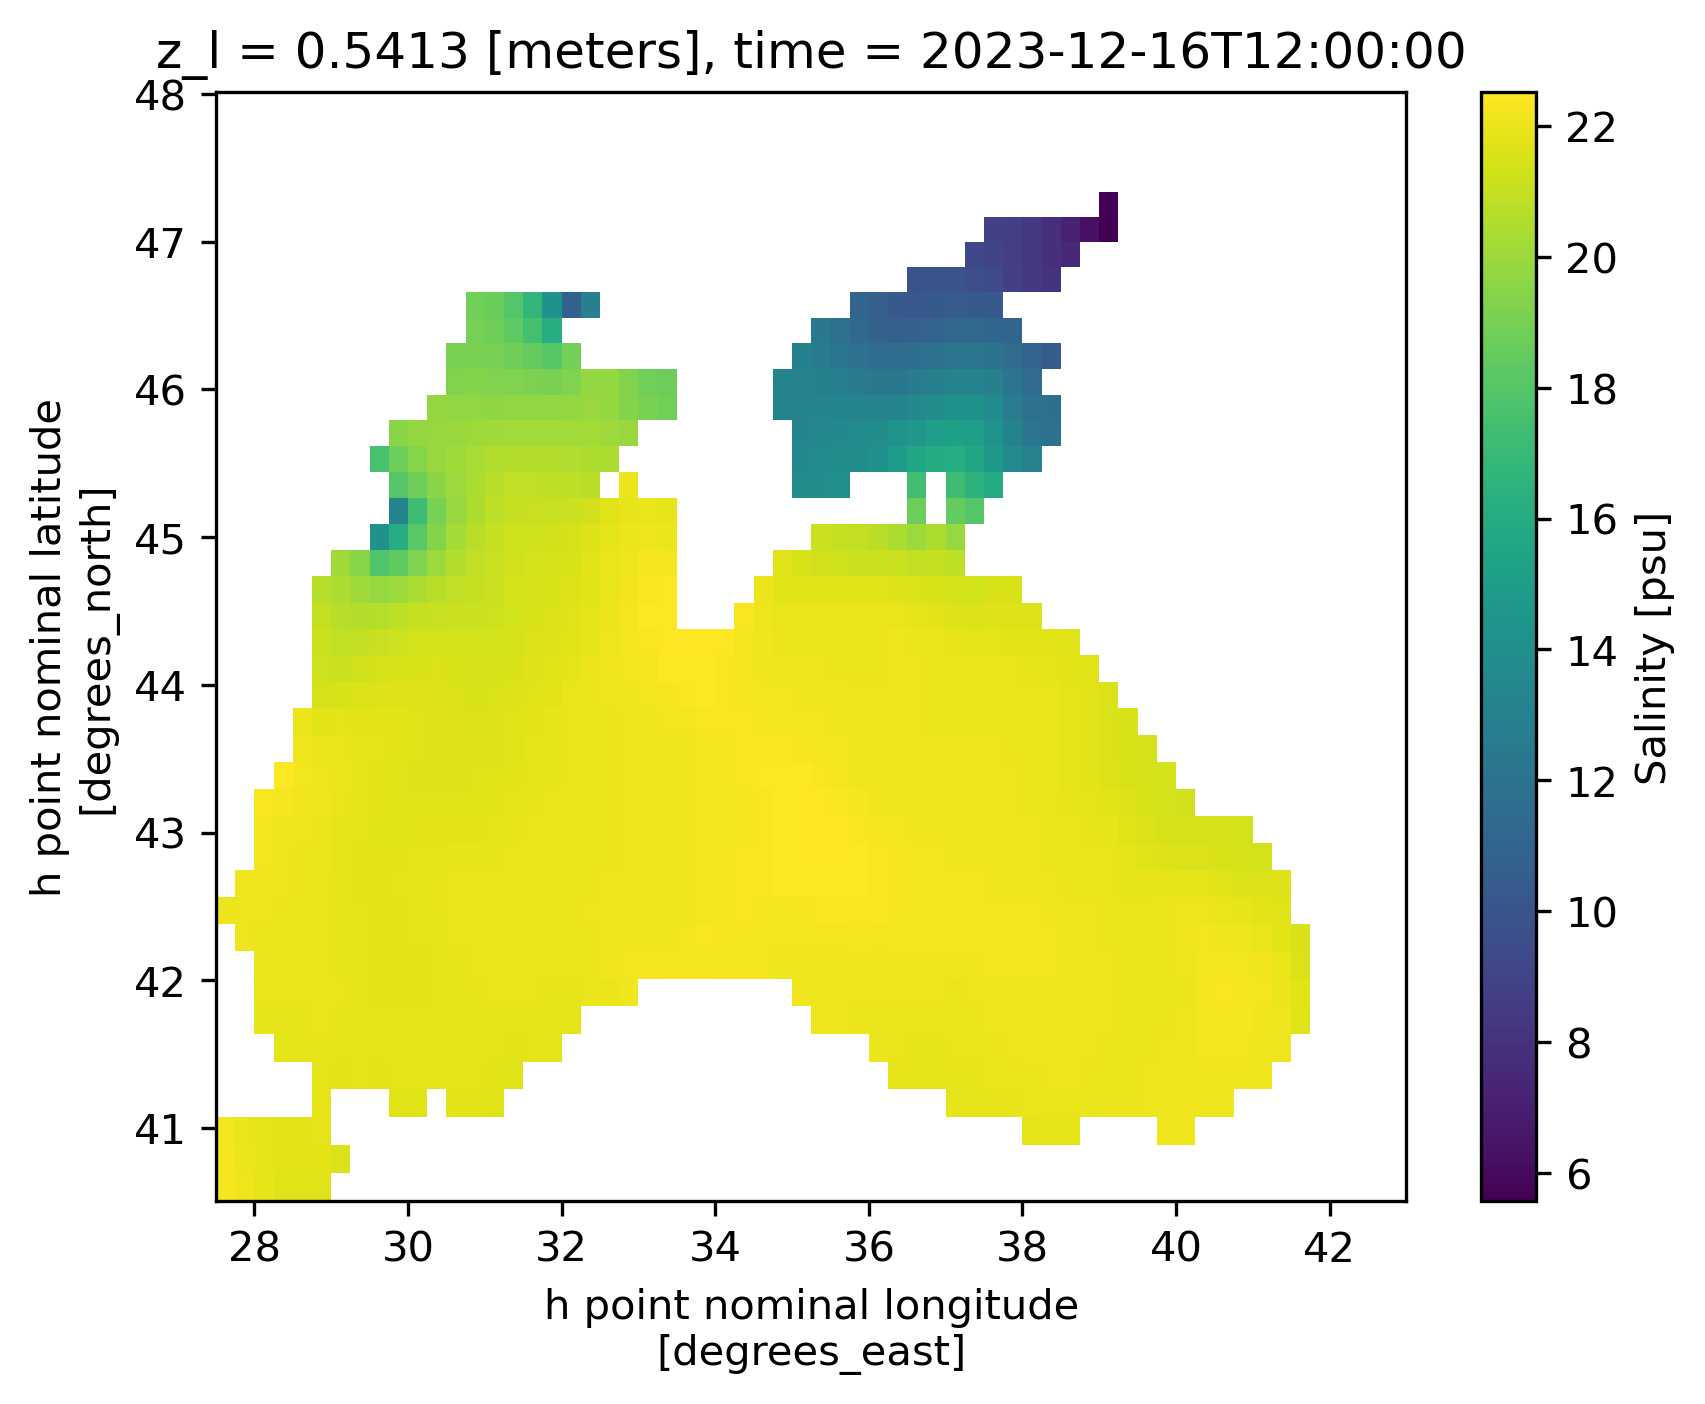

In [15]:
%%time
model_all.sel(xh=xslice).sel(yh=yslice).isel(time=-1).isel(z_l=0).plot()

In [16]:
%%time
model = model_all.sel(xh=xslice).sel(yh=yslice).mean('yh').mean('xh').load()

CPU times: user 4.16 s, sys: 1.31 s, total: 5.47 s
Wall time: 15.4 s


Text(0.5, 1.0, 'Black Sea UNWEIGHTED Horizontal mean Salinity drift from\ninitial condition in 25km-iaf-test-for-AK-expt-7df5ef4c')

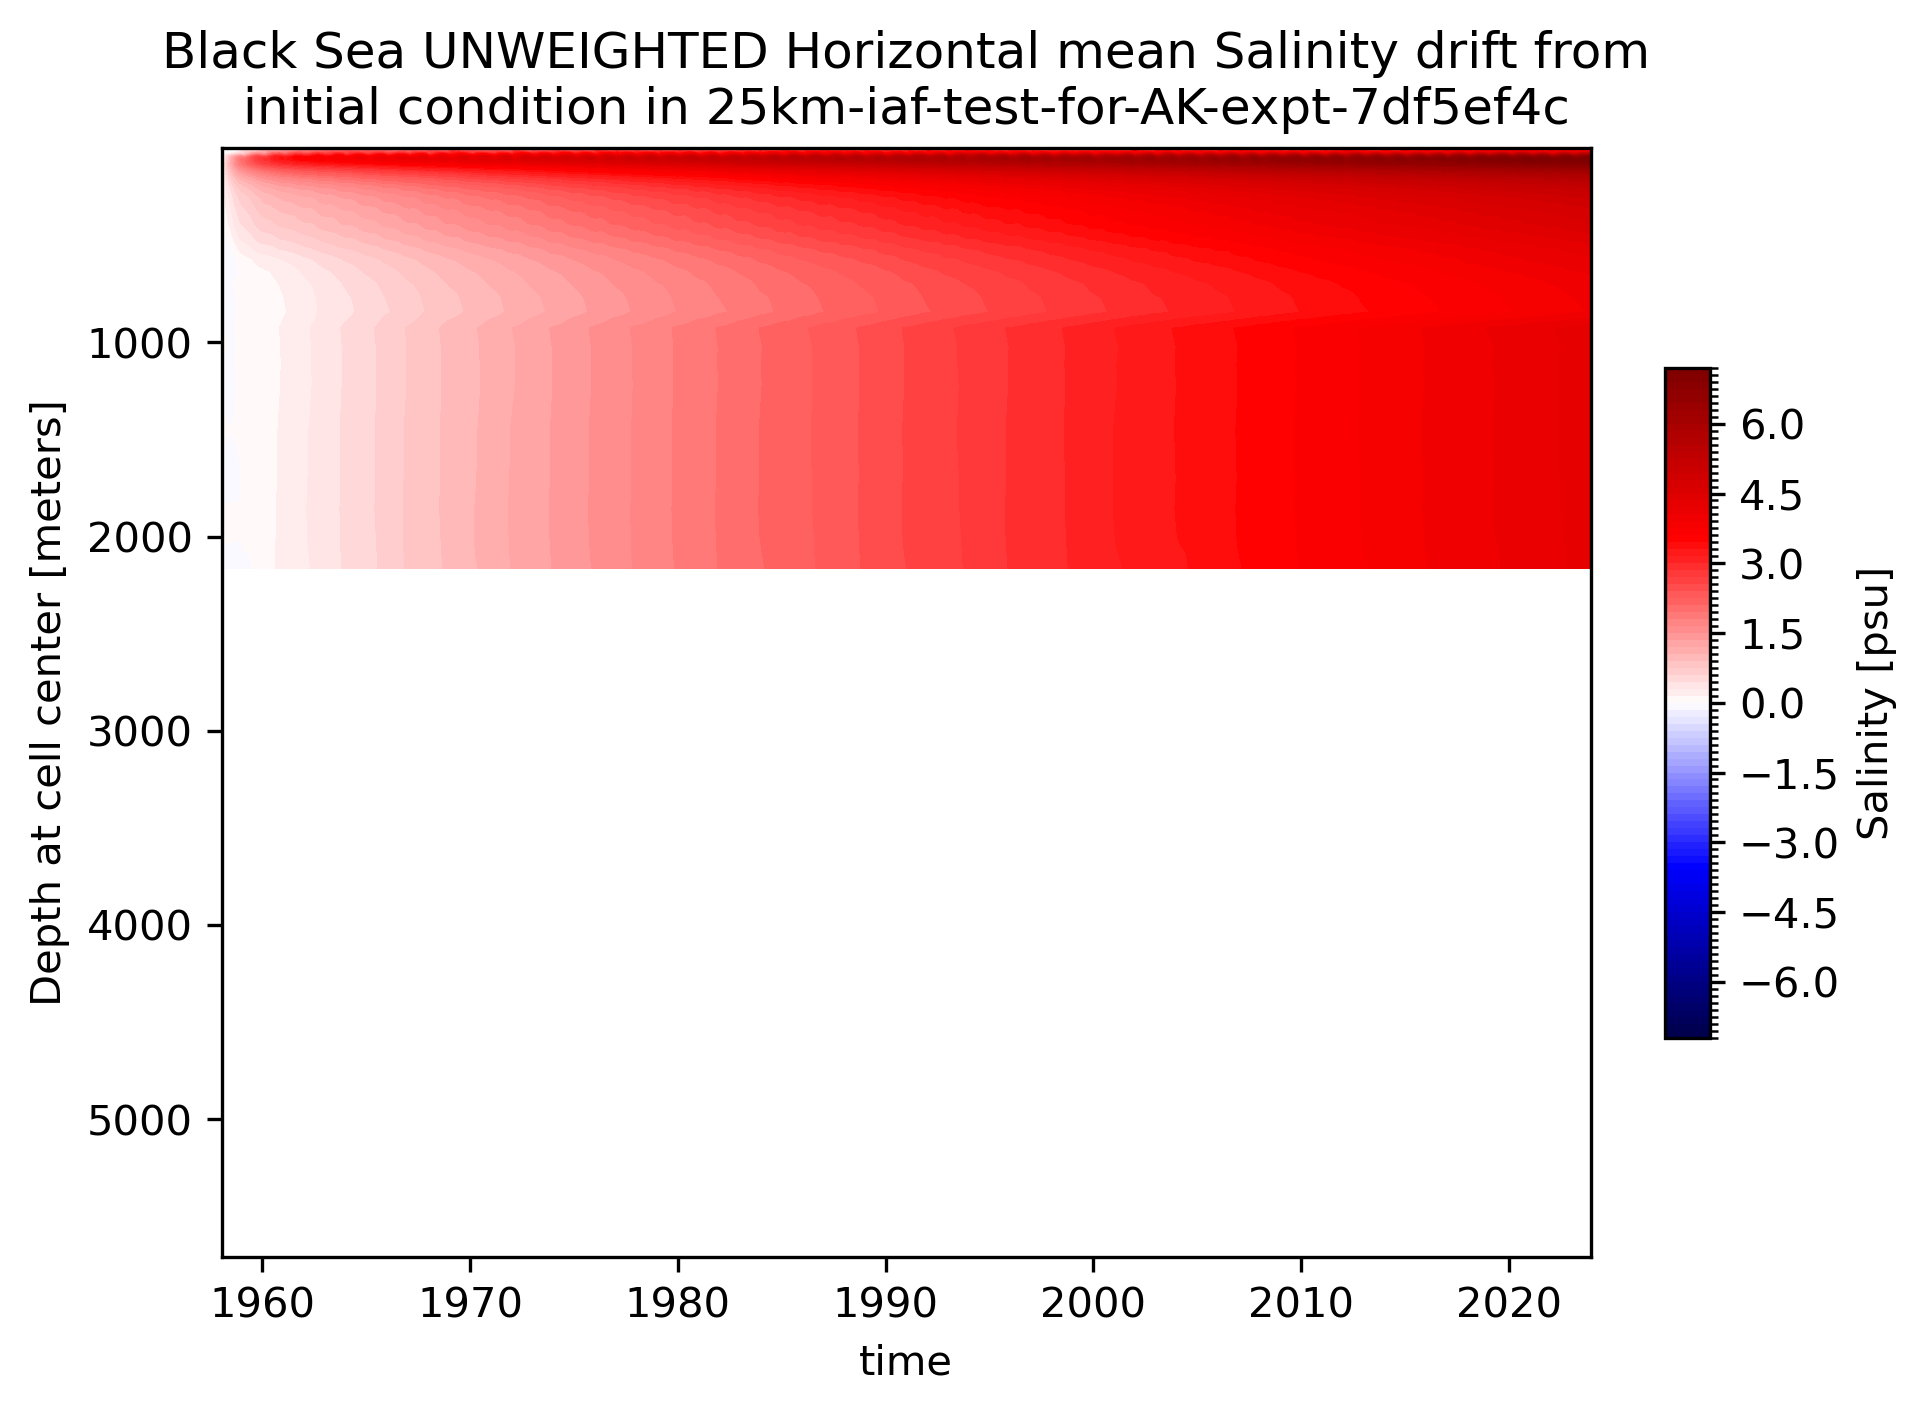

In [17]:
(model-model.isel(time=0)).transpose().plot.contourf(
    levels=101,
    # vmin=-0.3,
    # vmax=0.3,
    # extend="both",
    cmap='seismic',
    cbar_kwargs={"label": "\n".join(wrap(f"{model.attrs['long_name']} [{model.attrs['units']}]", 45)),
                 "fraction": 0.03, "aspect": 15, "shrink": 0.7},
)
plt.gca().invert_yaxis()
plt.title("\n".join(wrap(f"Black Sea UNWEIGHTED Horizontal mean {model.attrs['long_name']} drift from initial condition in {exptname}", 60)))

### Aegean Sea
- https://github.com/ACCESS-NRI/access-om3-configs/issues/729

In [18]:
# match SSS_Restoring_Timeseries.ipynb
# "Aegean Sea": {"lat1": 34, "lat2": 44, "lon1": 18, "lon2": 27.5},
xslice = slice(18, 27.5)
yslice = slice(34, 44)

CPU times: user 1.32 s, sys: 285 ms, total: 1.61 s
Wall time: 4.39 s


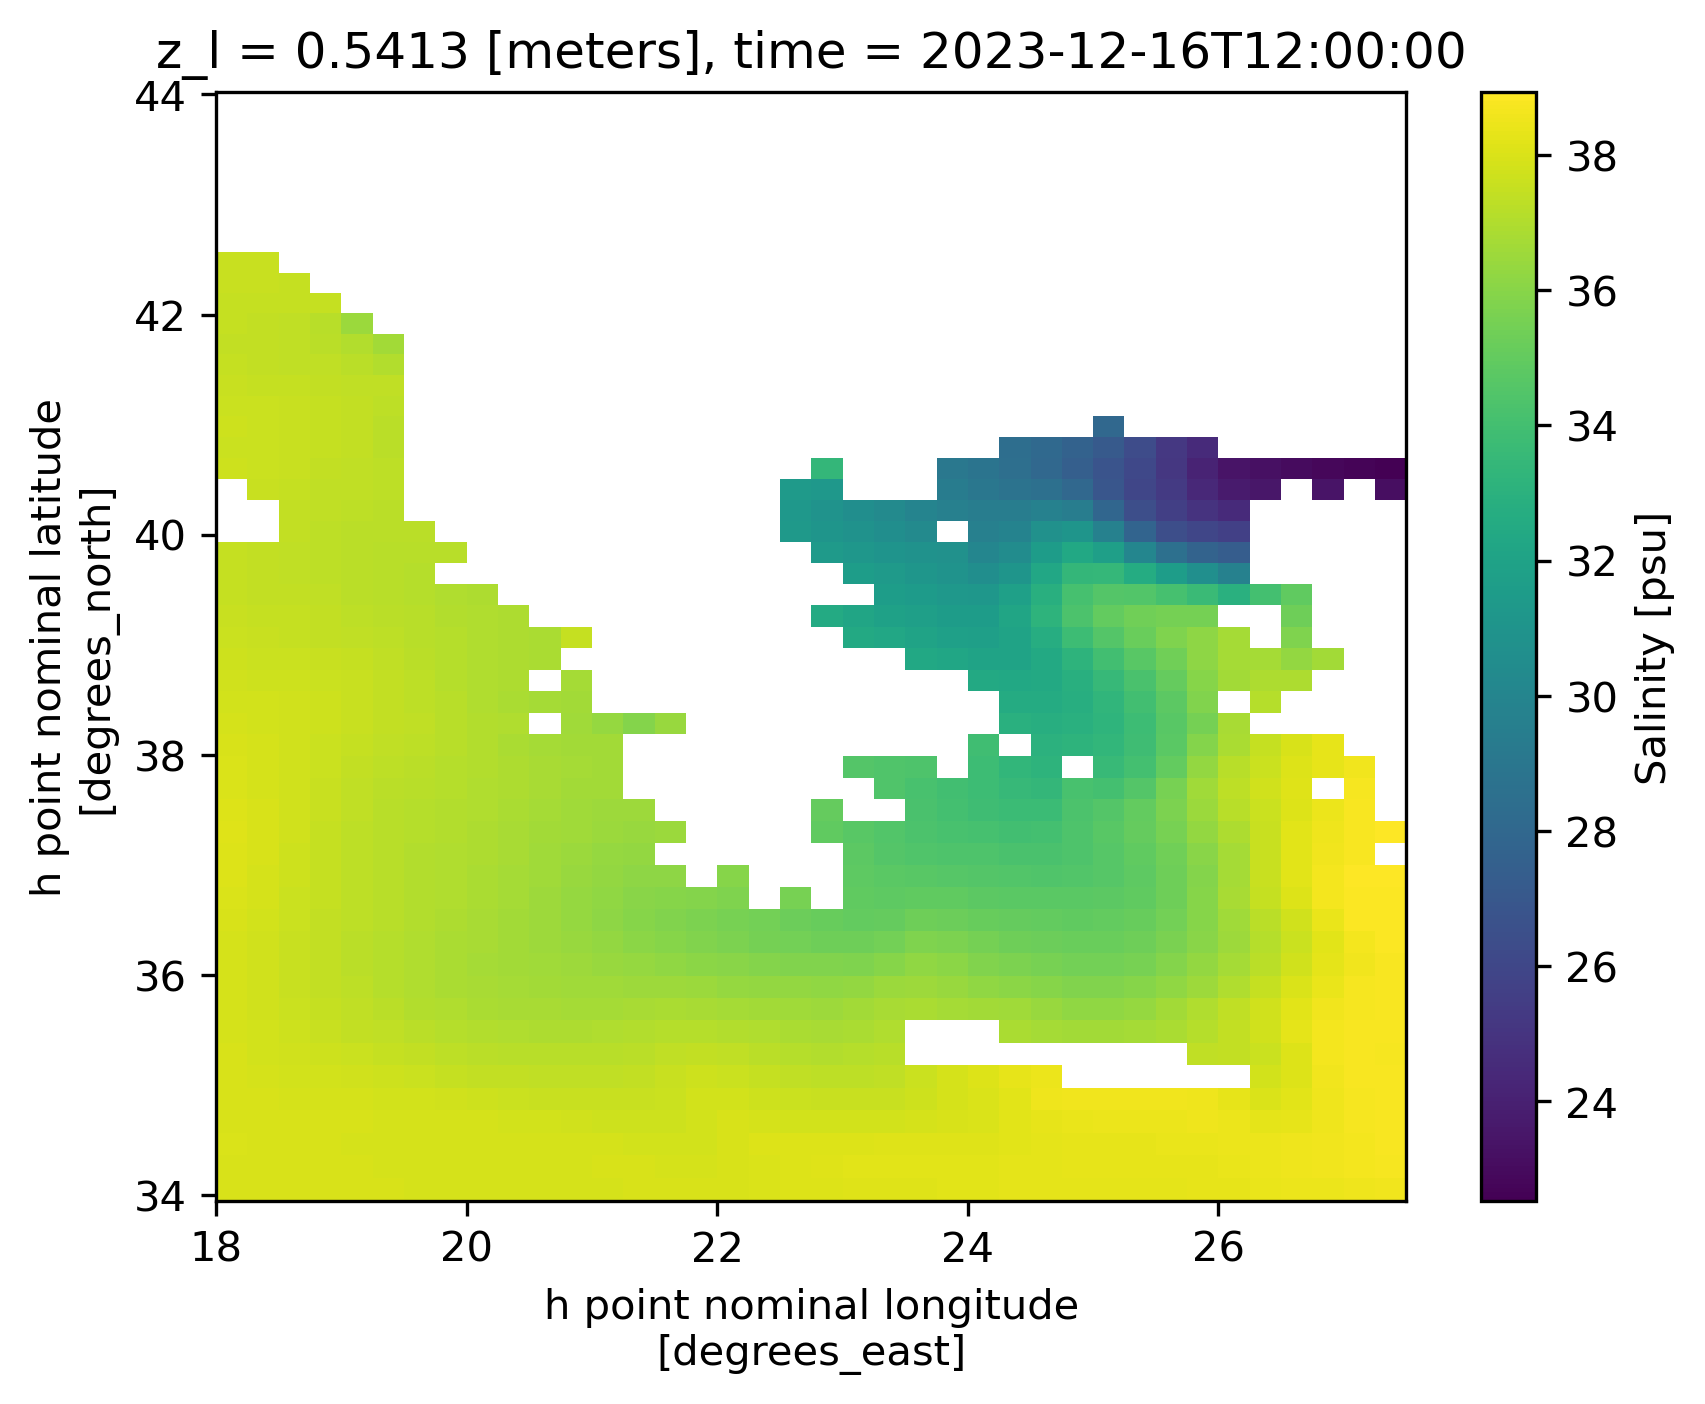

In [19]:
%%time
model_all.sel(xh=xslice).sel(yh=yslice).isel(time=-1).isel(z_l=0).plot()

In [20]:
%%time
model = model_all.sel(xh=xslice).sel(yh=yslice).mean('yh').mean('xh').load()

CPU times: user 8.13 s, sys: 2.24 s, total: 10.4 s
Wall time: 27.8 s


Text(0.5, 1.0, 'Aegean Sea UNWEIGHTED Horizontal mean Salinity drift from\ninitial condition in 25km-iaf-test-for-AK-expt-7df5ef4c')

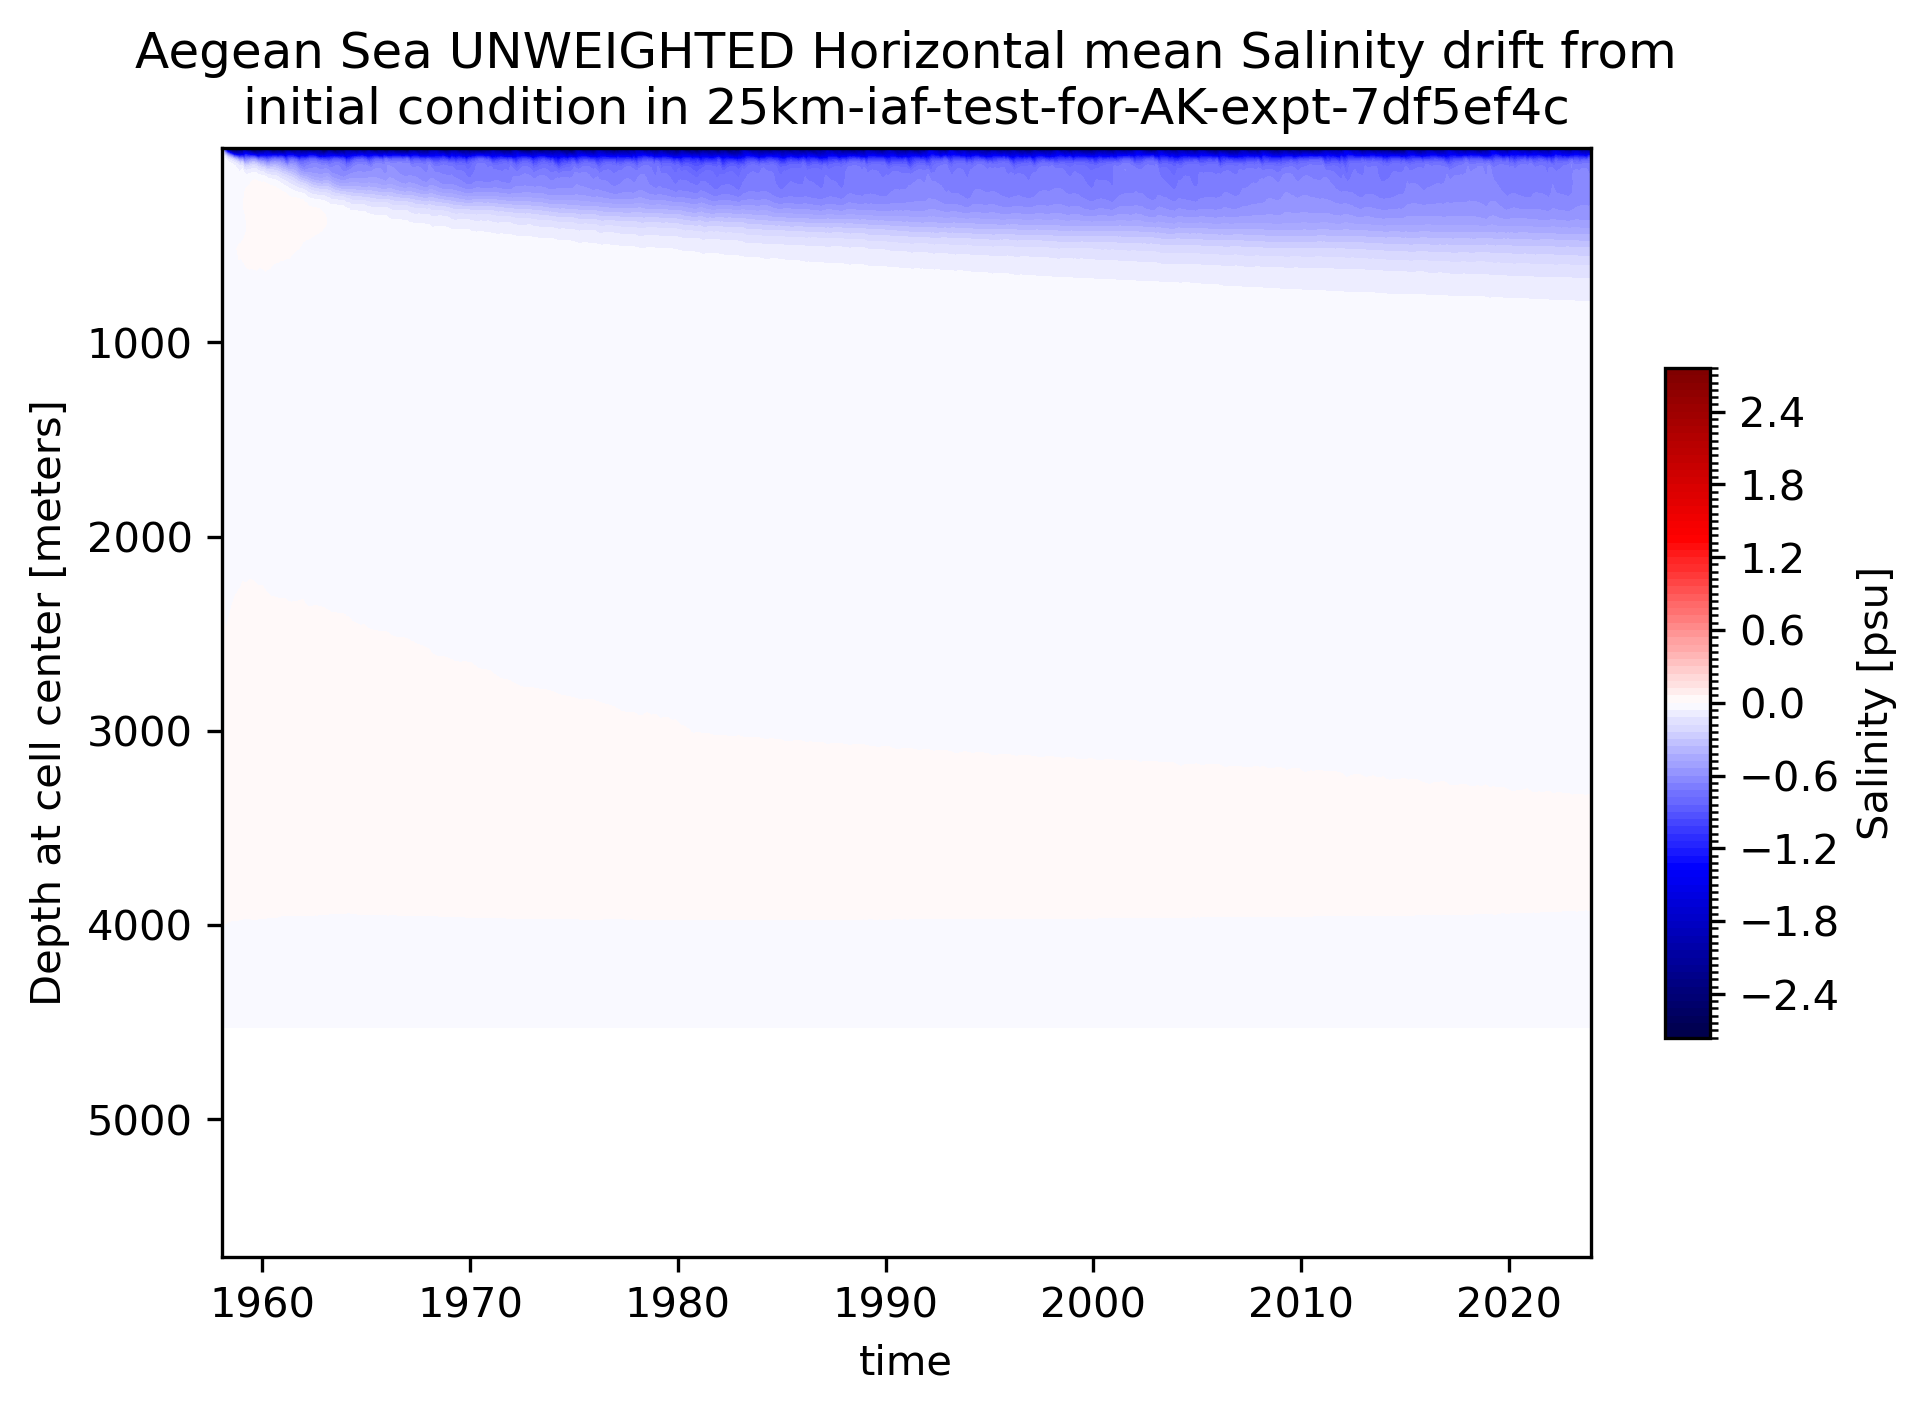

In [21]:
(model-model.isel(time=0)).transpose().plot.contourf(
    levels=101,
    # vmin=-0.3,
    # vmax=0.3,
    # extend="both",
    cmap='seismic',
    cbar_kwargs={"label": "\n".join(wrap(f"{model.attrs['long_name']} [{model.attrs['units']}]", 45)),
                 "fraction": 0.03, "aspect": 15, "shrink": 0.7},
)
plt.gca().invert_yaxis()
plt.title("\n".join(wrap(f"Aegean Sea UNWEIGHTED Horizontal mean {model.attrs['long_name']} drift from initial condition in {exptname}", 60)))

### Load and plot data from ACCESS-OM2
use control - see https://forum.access-hive.org.au/t/access-om2-control-experiments/258#p-747-ryf-7

In [22]:
# om2exptname = '025deg_jra55_ryf9091_gadi'
om2exptname = '025deg_jra55_iaf_omip2_cycle1'
datastore = intake.cat.access_nri[om2exptname]

ComputeError: invalid utf-8 sequence

In [ ]:
# for 025deg_jra55_ryf9091_gadi
# variable = "temp"  # NB: using top level of annual-mean 3D temp, as surface_temp not available for 025deg_jra55_ryf9091_gadi, and also has monthly data only for 1900-1903, and 2300-, with annual data in the gap
# frequency = "1yr"

# for 025deg_jra55_iaf_omip2_cycle1
variable = "salt"
frequency = "1mon"

om2model_all = datastore.search(variable=variable, frequency=frequency).to_dask(
    xarray_open_kwargs = dict(
        chunks={"time": -1},
        decode_timedelta=True
    ),
    xarray_combine_by_coords_kwargs=dict(
        compat="override",
        data_vars="minimal",
        coords="minimal"
    )
)[variable]

# BUG: horizontal mean needs to be area-weighted - use xgcm?

In [ ]:
%%time
om2model = om2model_all.mean('yt_ocean').mean('xt_ocean').load()

In [ ]:
(om2model-om2model.isel(time=0)).transpose().plot.contourf(
    levels=101,
    vmin=-0.3,
    vmax=0.3,
    # extend="both",
    cmap='seismic',
    cbar_kwargs={"label": "\n".join(wrap(f"{om2model.attrs['long_name']} [{om2model.attrs['units']}]", 45)),
                 "fraction": 0.03, "aspect": 15, "shrink": 0.7},
)
plt.gca().invert_yaxis()
plt.title("\n".join(wrap(f"UNWEIGHTED Horizontal mean {om2model.attrs['long_name']} drift from initial condition in {om2exptname}", 60)))


In [ ]:
client.close()